In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../')


# Data imports
from src_experiment import get_moons_data, get_wbc_data
# Paths imports
from src_experiment import moon_path, wbc_path
# Estimator imports
from src_experiment import EstimateQuantities1Run, AverageEstimates
# Visualization imports
from visualization import plot_training, plot_training_sweep, plot_all_quantities, plot_average_KL

In [2]:
# possible values for parameters
arches = ["small", "decreasing"]
dropouts = [0.0, 0.05, 0.1, 0.15, 0.2]
noises = [0.0, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8]
run_numbers = [0,2,4,5,6,8,9,10,11,12,13,14,15,18,19]

# Training

## Single run

In [3]:
# Parameters
def show_training(experiment, **kwargs):
    path = moon_path(**kwargs) if experiment == "moons" else wbc_path(**kwargs)
    training_data = pd.read_csv(os.path.join(path, "run_summary.csv"))
    title = f"Training results for {experiment} with arch={kwargs.get('arch')}, dropout={kwargs.get('dropout')}, noise={kwargs.get('noise')}, run_number={kwargs.get('run_number')}"
    plot_training(training_data, title=title)


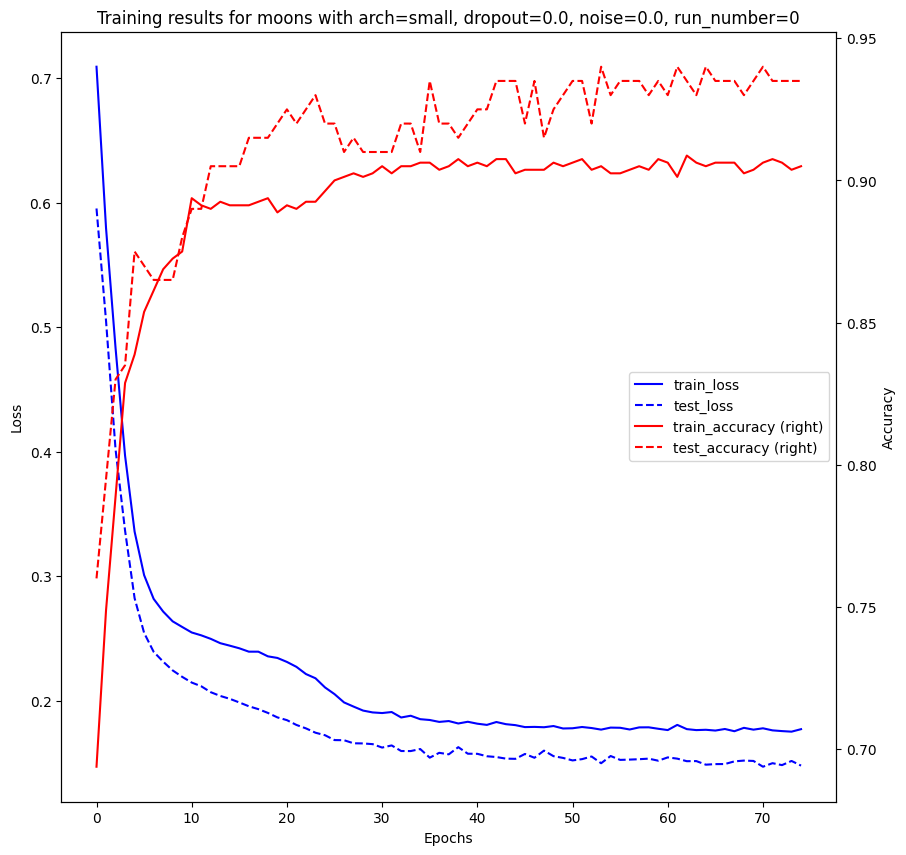

In [4]:
show_training("moons", arch="small", dropout=0.0, noise=0.0, run_number=0)

## Sweep

In [5]:
base_params = {
    "arch": "small",
    "dropout": 0.1,
    "noise": 0.0,
    "run_number": 0,
}

### Across architectures

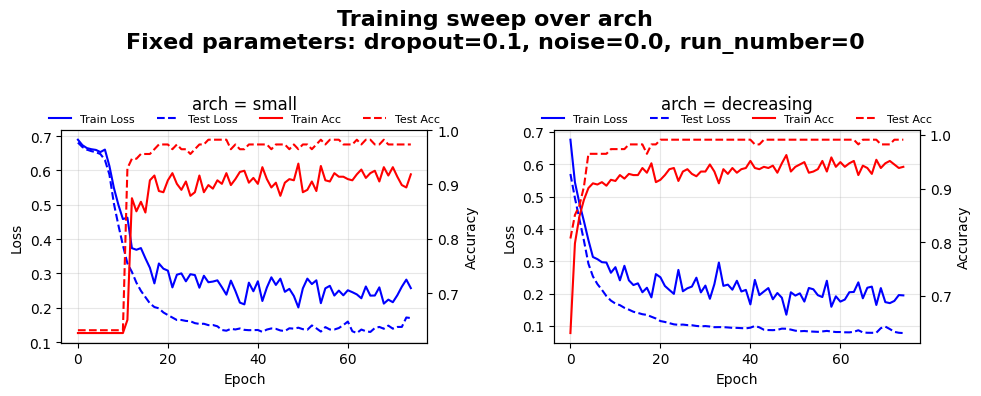

In [6]:
plot_training_sweep(
    vary="arch",
    values=arches,
    **base_params,
    path_fn=wbc_path,)

### Across dropouts

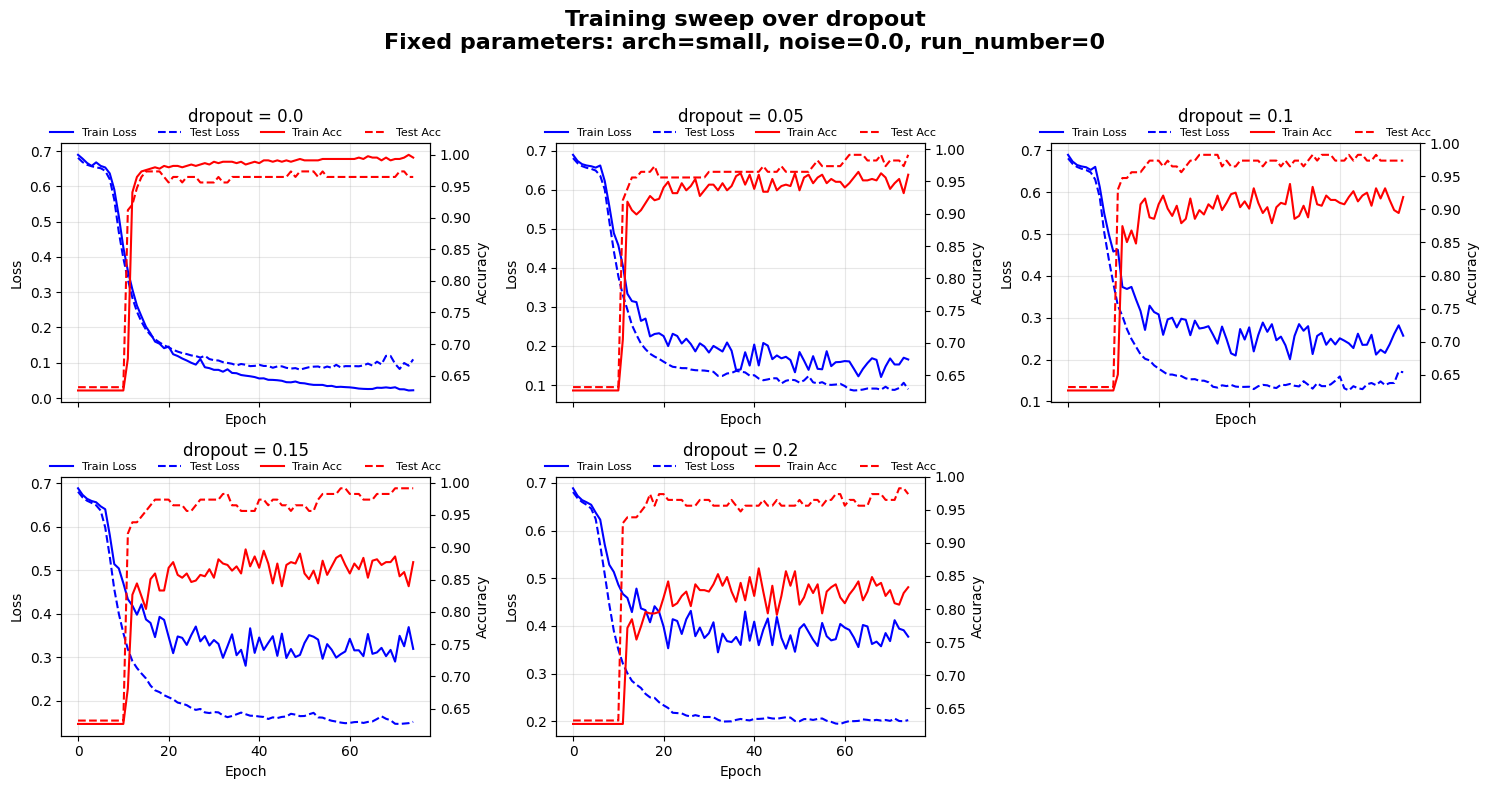

In [7]:
plot_training_sweep(
    vary="dropout",
    values=dropouts,
    **base_params,
    path_fn=wbc_path,)

### Across noises

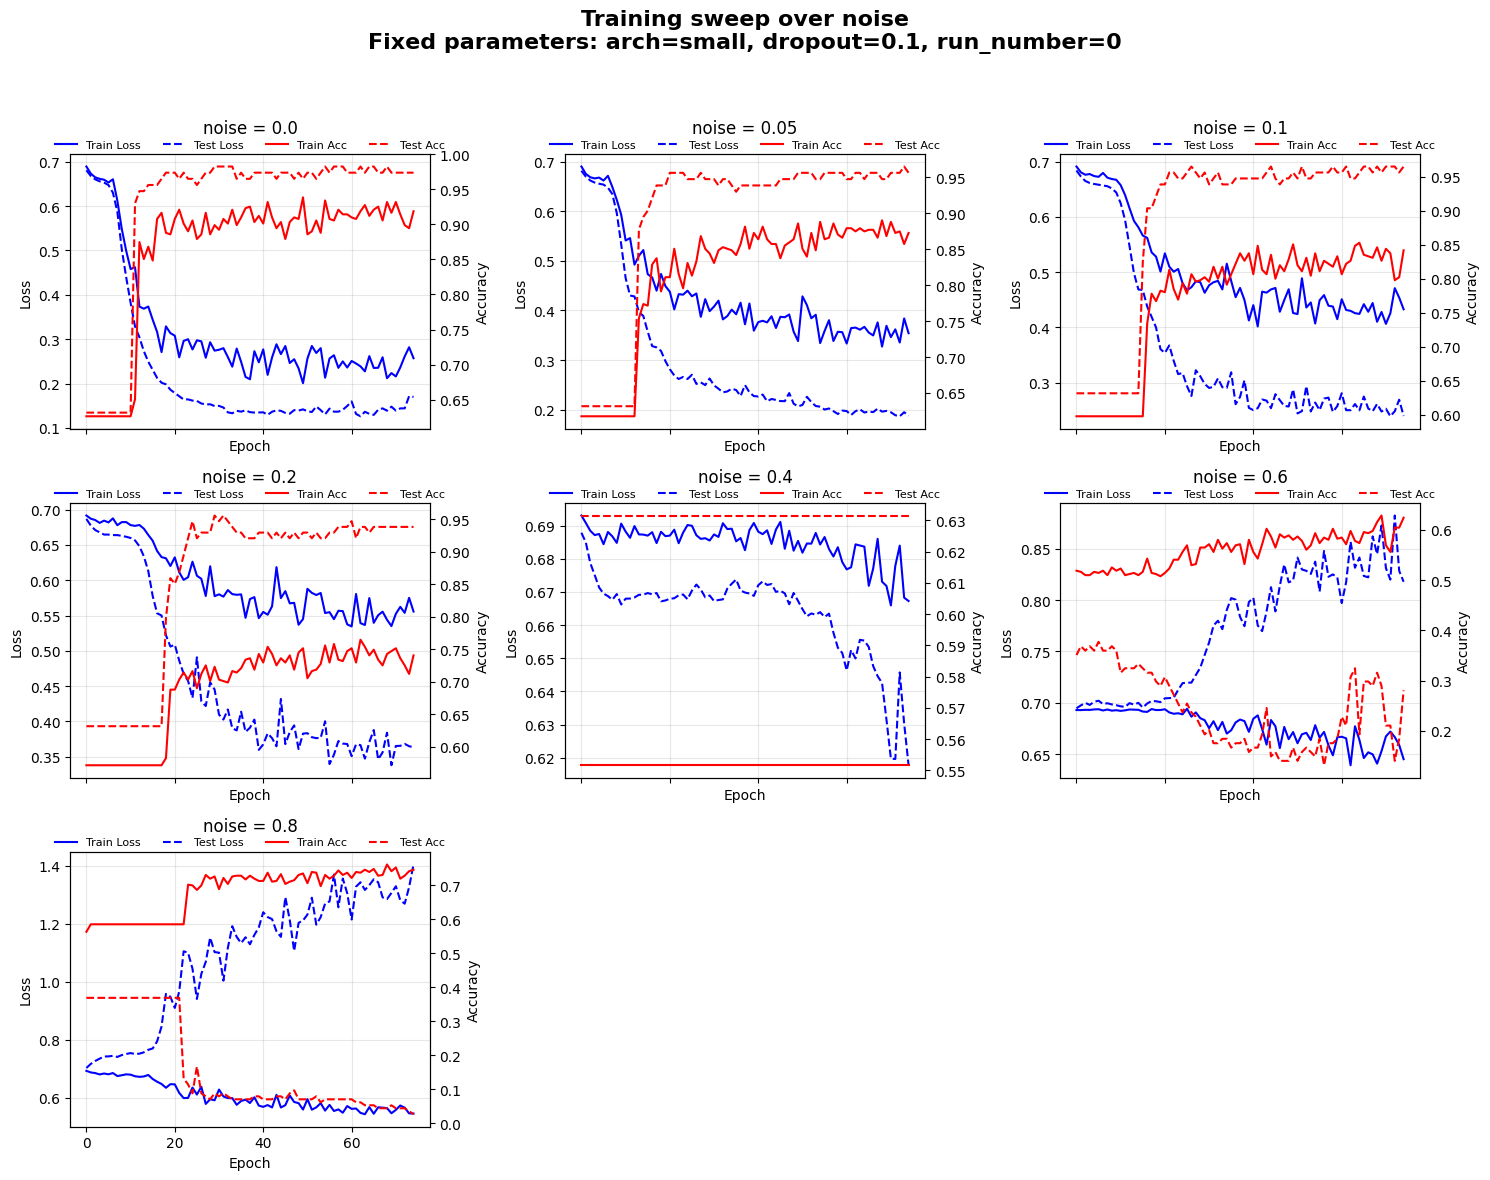

In [8]:
plot_training_sweep(
    vary="noise",
    values=noises,
    **base_params,
    path_fn=wbc_path,)

### Across run numbers

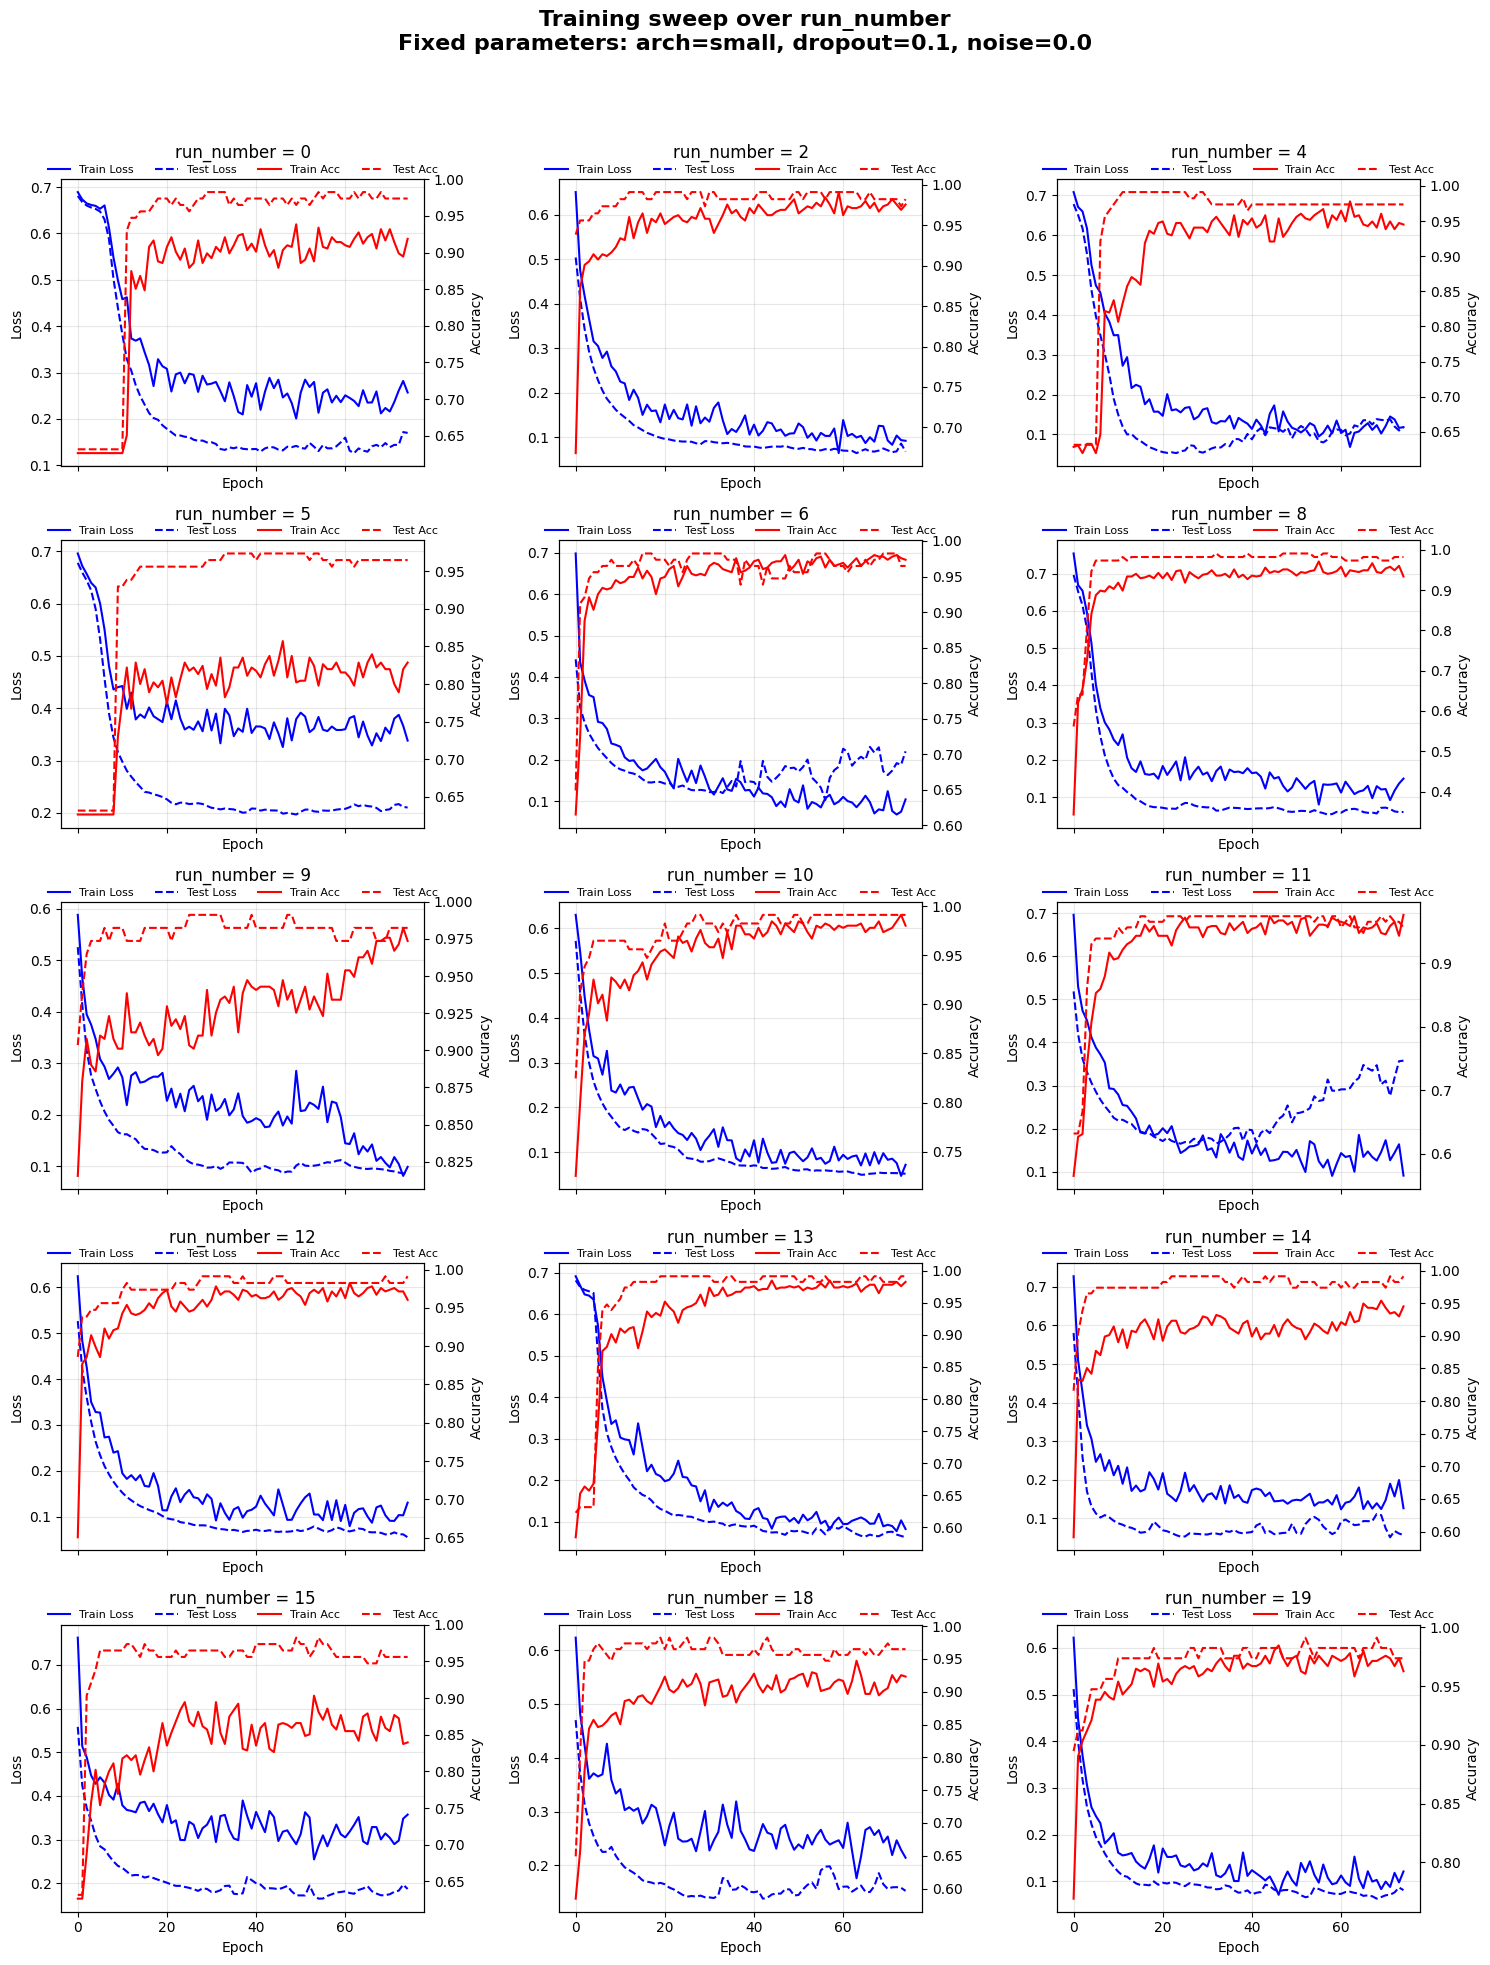

In [9]:
plot_training_sweep(
    vary="run_number",
    values=run_numbers,
    **base_params,
    path_fn=wbc_path,)

# Estimates

## Single run

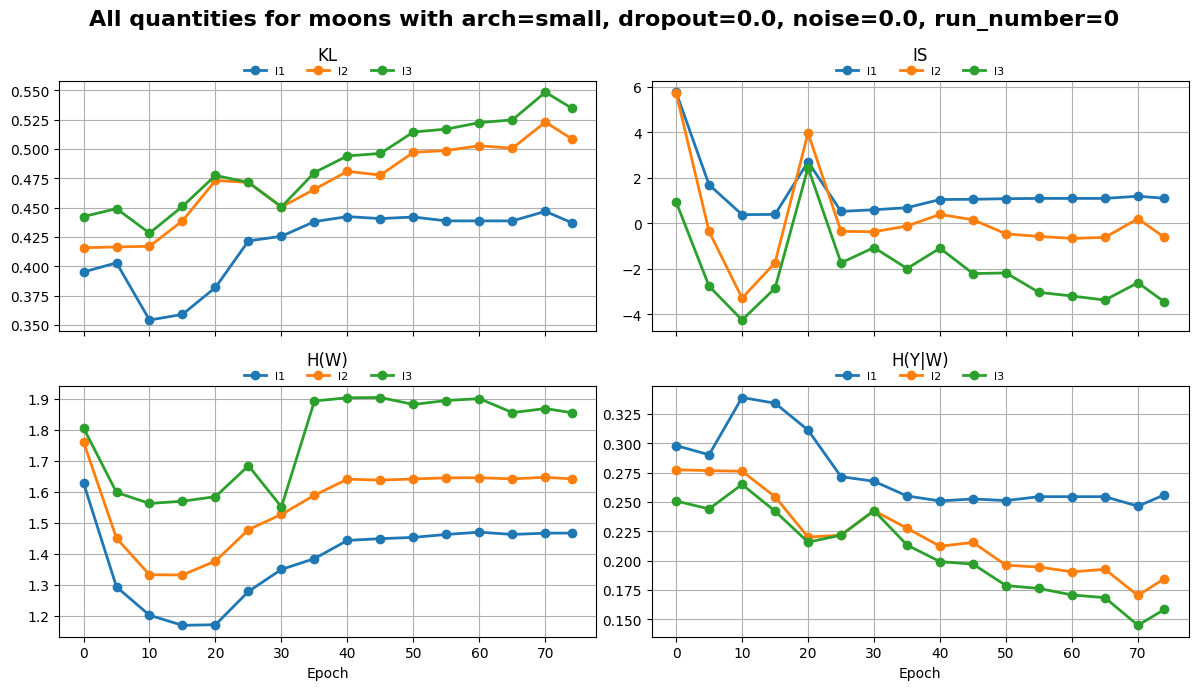

In [10]:
params = {
    "arch": "small",
    "dropout": 0.0,
    "noise": 0.0,
    "run_number": 0,
}
experiment = "moons"
path = wbc_path(**params) if experiment == "wbc" else moon_path(**params)

Q = EstimateQuantities1Run(path)
plot_all_quantities(Q.get_estimates(), super_title = f"All quantities for {experiment} with arch={params['arch']}, dropout={params['dropout']}, noise={params['noise']}, run_number={params['run_number']}")

## Averages

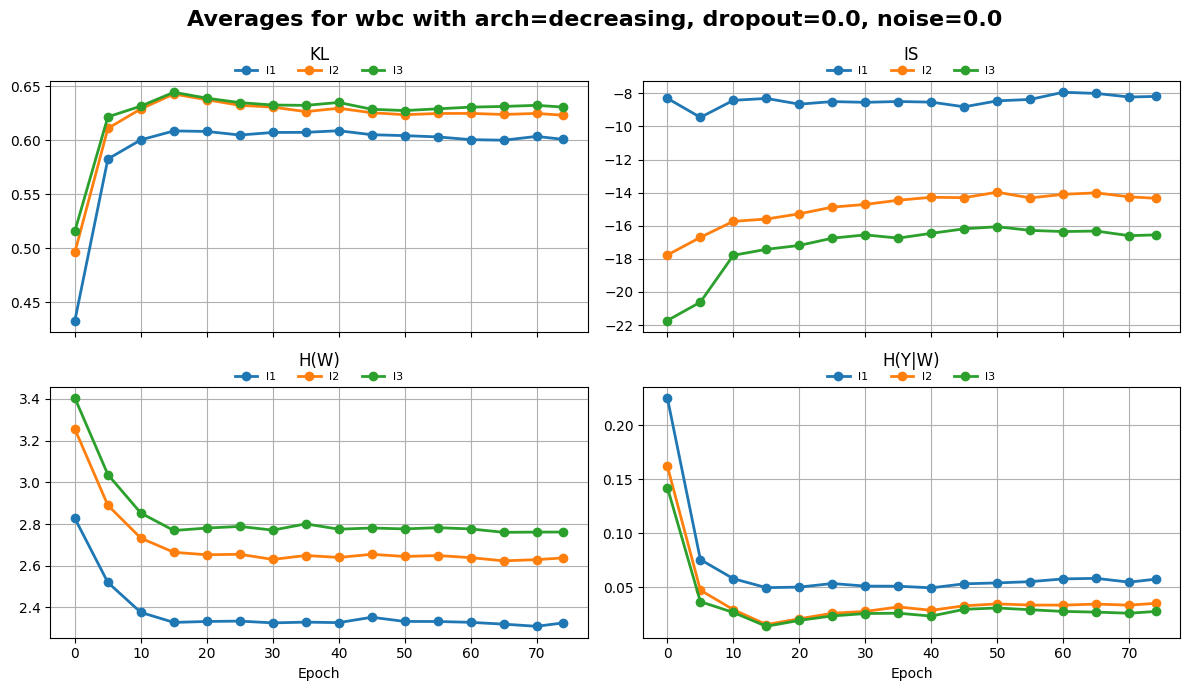

In [11]:
avg_params = {
    "arch": "decreasing",
    "dropout": 0.0,
    "noise": 0.0,
}
experiment = "wbc"
path_fn = wbc_path if experiment == "wbc" else moon_path

avgQ = AverageEstimates([path_fn(**avg_params, run_number=rn) for rn in run_numbers])
plot_all_quantities(avgQ.means, super_title=f"Averages for {experiment} with arch={avg_params['arch']}, dropout={avg_params['dropout']}, noise={avg_params['noise']}")

## Investigate KL as function of noise

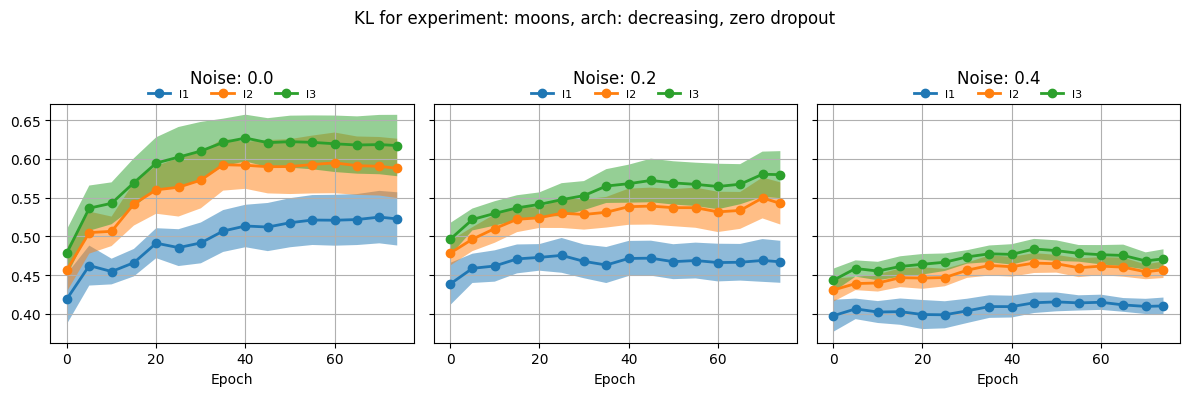

In [12]:
avg_params = {
    "arch": "decreasing",
    "dropout": 0.0,
}
experiment = "moons"
path_fn = wbc_path if experiment == "wbc" else moon_path

average_KLs = {}
std_KLs = {}
for noise in noises:
    avgKL = AverageEstimates([path_fn(**avg_params, noise=noise, run_number = rn) for rn in run_numbers])
    average_KLs[f"{noise}"] = avgKL.means["Kullback-Leibler"]
    std_KLs[f"{noise}"] = avgKL.stds["Kullback-Leibler"]
    
    
def plot_average_KL_together(frames, noises, stds=None, super_title="", **kwargs):
    r=1/2 # How much of the standard deviation should be shown?
    fig, axes = plt.subplots(ncols=len(noises), nrows=1, sharey=True, figsize=(4*len(noises),4))
    for ax, noise in zip(axes, noises):
        frame = frames[f"{noise}"] 
        for layer in frame.columns[1:-1]:
                if stds is not None:
                    std_frame = stds[f"{noise}"]
                    ax.fill_between(std_frame["epoch"], frame[layer]-r*std_frame[layer], frame[layer]+r*std_frame[layer], alpha=0.5)
                    ax.plot(frame["epoch"], frame[layer], ls="-", lw=2, marker="o", label=layer, **kwargs)
                else:
                    ax.plot(frame["epoch"], frame[layer], ls="-", lw=2, marker="o", label=layer, **kwargs)
                ax.set_title(f"Noise: {noise}", pad=15)
                ax.grid(True)
                ax.legend(loc="lower center",
                bbox_to_anchor=(0.5, 0.98),
                ncol=4,
                fontsize=8,
                frameon=False,)
                ax.set_xlabel("Epoch")
    fig.suptitle(super_title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
plot_average_KL_together(average_KLs, [0.0,0.2,0.4], stds=std_KLs, super_title=f"KL for experiment: {experiment}, arch: {avg_params["arch"]}, zero dropout")

In [13]:
# for noise in noises:
#     plot_average_KL(average_KLs[f"{noise}"], noise=noise, title=f"KL for noise: {noise}")

## Sweep across quantities

# Generalisation capabilities - Compare with Wongso

## Generalization Gap

__What is it?__
It is the difference between training and testing performance.

$$
    GG_L = L_\mathrm{test}-L_\mathrm{train},
$$
or
$$
    GG_A = A_\mathrm{train}-A_\mathrm{test},
$$
with the following interpretations:

* __Positive gap__ $\to$ worse performance on unseen data (overfitting)
* __Zero gap__ $\to$ perfect generalization
* __Negative gap__ $\to$ test performance is better than training (regularization, noise)


__IS THIS A GOOD IDEA?__
We can define the generalisation gap as the average of the two previous definitions:

$$
    GG = \frac{1}{2} \left( L_\mathrm{test}-L_\mathrm{train} +  A_\mathrm{train}-A_\mathrm{test}  \right)
$$

In [14]:
ggparams = {
    "arch": "small",
    "dropout": 0.0,
    "noise": 0.0,
    "run_number": 0,
}
experiment = "moons"
average_from_epoch = 60
path = moon_path(**ggparams) if experiment == "moons" else wbc_path(**ggparams)

# get the training results: 


In [15]:

from src_experiment import get_model
import torch
import torch.nn as nn


# Make data lookup table for the noises:
epochs = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,74]
moons_lookup = {}
wbc_lookup = {}
for noise in noises:
    moons_lookup[noise] = get_moons_data(feature_noise=noise)
    wbc_lookup[noise] = get_wbc_data(label_noise=noise)
    
data_lookup = {
    "moon": moons_lookup,
    "wbc": wbc_lookup,
}

path_fns = {
    "moon": moon_path,
    "wbc": wbc_path,
}

def generalization_gap(experiment, arch, dropout, noise, run_number, epoch=epochs[-1]):
    # 1. Load the model with correct configurations (need arch, dropout and run_number)
    # Generate model
    model = get_model(f"{arch}_{experiment}", dropout=dropout, seed=run_number)
    path_fn = path_fns[experiment]
    # Find state dict
    state_dict = path_fn(arch, dropout, noise, run_number) / "state_dicts" / f"epoch{epoch}.pth"
    # Load model with state dict and set eval mode
    model.load_state_dict(torch.load(state_dict, weights_only=True))
    model.eval()

    # 2. Load the corresponding data noise
    D_train, D_test = data_lookup[experiment][noise]
    
    # 3. While model in eval mode, evaluate on the training and testing data, finding the corresponsing accuracy. 
    return find_gg_gap(model, D_train, D_test) 
    
def find_gg_gap(model, train_data, test_data):
    model.eval()
    
    loss_fn = nn.BCEWithLogitsLoss()
    sigmoid = nn.Sigmoid()

    # Evaluate on training data
    running_loss = 0.0
    num_correct = 0
    total_samples = 0
    with torch.no_grad():
        for x, y in train_data:
            x = x.float()
            y = y.unsqueeze(1).float()

            y_hat = model(x)
            loss = loss_fn(y_hat, y)

            preds = sigmoid(y_hat) > 0.5
            running_loss += loss.item()
            num_correct += (preds == y.bool()).sum().item()
            total_samples += y.size(0)
    train_loss = running_loss / len(train_data)
    train_accuracy = num_correct / total_samples
    
    # Repeat on testing data
    running_loss = 0.0
    num_correct = 0
    total_samples = 0
    with torch.no_grad():
        for x, y in test_data:
            x = x.float()
            y = y.unsqueeze(1).float()

            y_hat = model(x)
            loss = loss_fn(y_hat, y)

            preds = sigmoid(y_hat) > 0.5
            running_loss += loss.item()
            num_correct += (preds == y.bool()).sum().item()
            total_samples += y.size(0)
    
    test_loss = running_loss / len(train_data)
    test_accuracy = num_correct / total_samples
    
    # GENERALIZATION GAP
    gg = train_loss - test_loss
    # gg = train_accuracy - test_accuracy
    
    return gg
    

In [16]:
generalization_gap(
    "moon",
    "decreasing",
    dropout=0.0,
    noise=0.0,
    run_number=0
)

0.006922298260033131

## MI from penultimate layer

In [17]:
def get_penultimate_MI(summary_path, layer=-2, average_from_epoch=epochs[-1]):
    # Get estimate
    Q = EstimateQuantities1Run(summary_path)
    est = Q.get_estimates()["Kullback-Leibler"]
    # Compute the mean from the included epochs values in the penultimate layer
    mean_MI = est.loc[est["epoch"] >= average_from_epoch].iloc[:, layer].mean()
    return mean_MI

In [18]:
get_penultimate_MI(path)

np.float64(0.5347552134018896)

## Attempt to replicate results

In [19]:
# Gather MI and generalization from multiple configurations

def get_gengap_data(
    experiment = "moon",
    arch = "small",
    ):
    # List to store data points:
    data_points = []
    
    # Loop through some configs to check:
    for dropout in dropouts:
        for noise in noises:
            for run_number in run_numbers[::5]:
                local_params = {
                    "arch": arch,
                    "dropout": dropout,
                    "noise": noise,
                    "run_number": run_number,
                    }
                local_path = moon_path(**local_params) if experiment == "moon" else wbc_path(**local_params)
                
                gg = generalization_gap(experiment, arch, dropout, noise, run_number)
                pen_mi = get_penultimate_MI(local_path, layer=-2)
                data_points.append((pen_mi, gg))
    return data_points
                

In [ ]:
def plot_gengap_points(data_points, title="Generalization Gap vs Penultimate MI"):
    """
    Plots a scatter of (penultimate MI, generalization gap) points.
    
    Args:
        data_points (list of tuples): Each tuple is (pen_mi, gg)
        title (str): Plot title
    """
    if not data_points:
        print("No data points to plot!")
        return
    
    # Unpack the tuples into two lists
    pen_mi_values, gg_values = zip(*data_points)
    
    plt.figure(figsize=(8,6))
    plt.scatter(pen_mi_values, gg_values, marker="x", color='blue', edgecolor='k', s=80, alpha=0.8)
    
    plt.xlabel("Penultimate Layer Mutual Information")
    plt.ylabel("Generalization Gap")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Optional: annotate points (small example)
    # for i, (x, y) in enumerate(data_points):
    #     plt.text(x, y, str(i), fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_58467/1820096323.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pen_mi_values, gg_values, marker="x", color='blue', edgecolor='k', s=80, alpha=0.8)


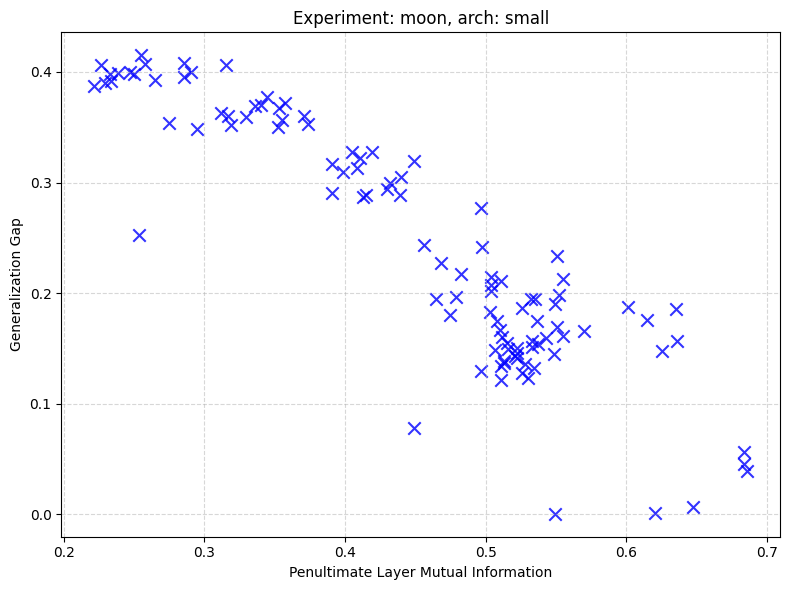

/tmp/ipykernel_58467/1820096323.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pen_mi_values, gg_values, marker="x", color='blue', edgecolor='k', s=80, alpha=0.8)


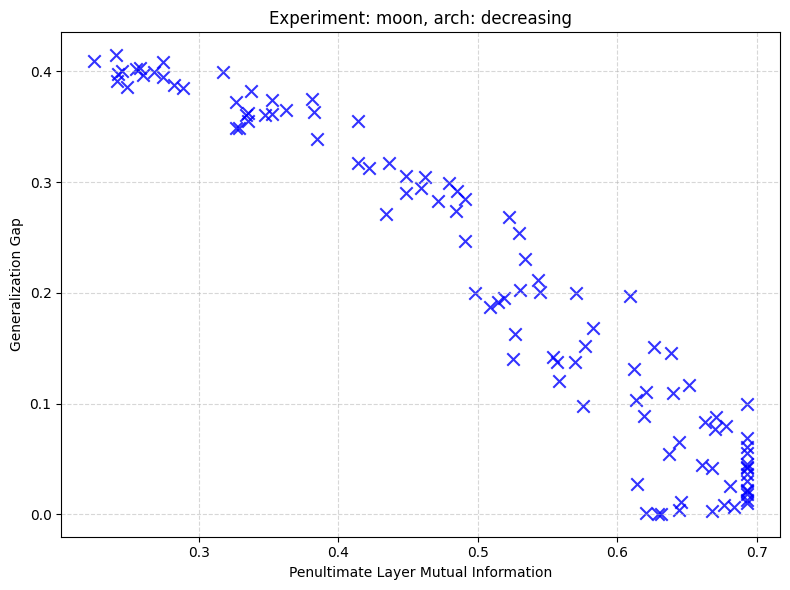

/tmp/ipykernel_58467/1820096323.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pen_mi_values, gg_values, marker="x", color='blue', edgecolor='k', s=80, alpha=0.8)


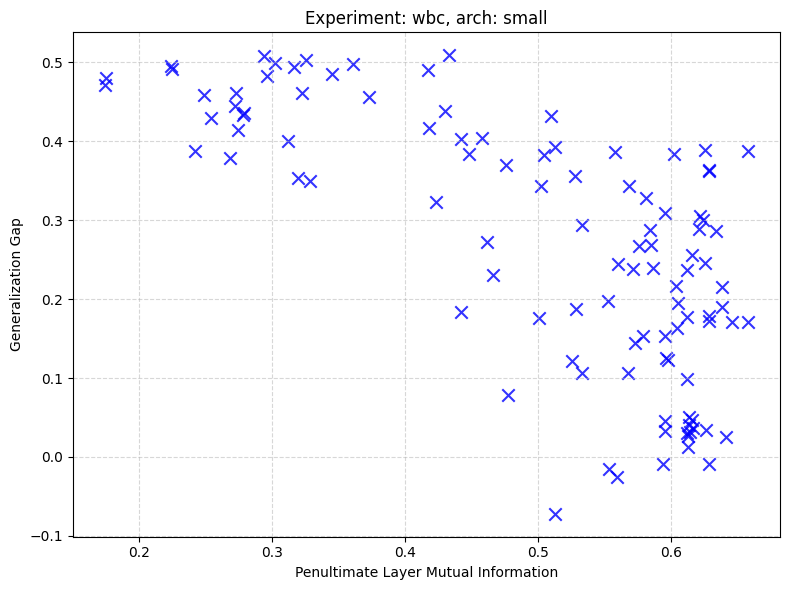

/tmp/ipykernel_58467/1820096323.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pen_mi_values, gg_values, marker="x", color='blue', edgecolor='k', s=80, alpha=0.8)


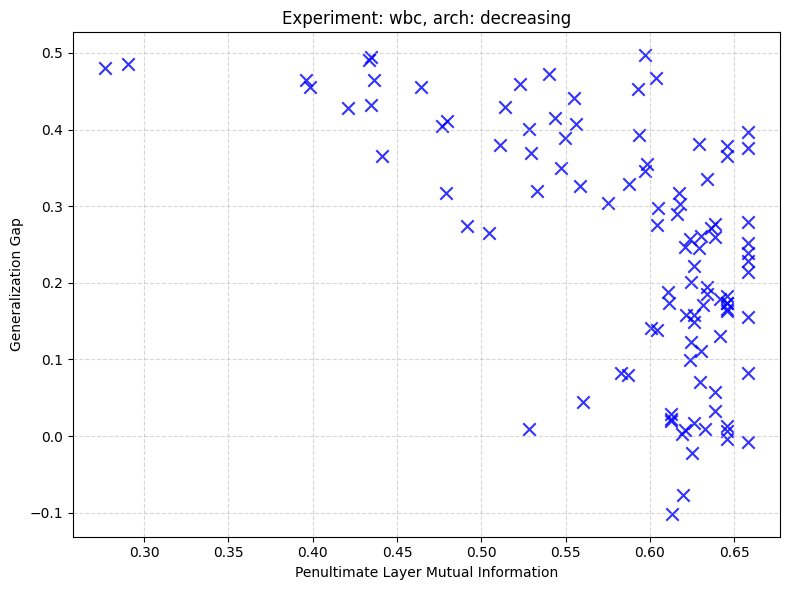

In [21]:
for experiment in ["moon", "wbc"]:
    for arch in ["small", "decreasing"]:
        plot_gengap_points(get_gengap_data(experiment, arch), title=f"Experiment: {experiment}, arch: {arch}")